# Figure 5: Stellar Mass and SFR Analysis

This notebook generates Figure 5 showing stellar mass (z=0) and specific SFR (z=0) distributions across UMAP space.

The figure shows:
1. Top row: Stellar mass point plots, averages, and SFHs across UMAP space
2. Bottom row: Specific SFR point plots, averages, and SFHs across UMAP space
3. Both rows share the same average SFH structure but with different coloring

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import sys
import pickle
import cmasher as cmr

# Add src to path
sys.path.append('../src')

from utils.analysis import (sim_name, colors, times, boxing, 
                           SM_axis_label, sSFR_axis_label)
from utils.plotting import draw_grid_D, plot_points, plot_averages

# LaTeX font setup
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%matplotlib inline

## Load Data and Reconstruct by Simulation

In [2]:
# Load processed simulation data
with open('../data/sim_data_processed.pkl', 'rb') as f:
    sim_data = pickle.load(f)

# Load UMAP embeddings and reconstruct by simulation
combined_labels = np.load('../data/combined_labels.npy')
embedding = np.load('../data/umap_embedding.npy')
combined_sfh = np.load('../data/combined_sfh.npy')

# Reconstruct UMAP embeddings and SFHs by simulation
for i, sim in enumerate(sim_name):
    if sim_data[sim] is not None:
        sim_mask = combined_labels == i
        sim_data[sim]['umap'] = embedding[sim_mask]
        sim_data[sim]['sfh'] = combined_sfh[sim_mask]

print("Reconstructed UMAP and SFH data by simulation:")
for sim in sim_name:
    if sim_data[sim] is not None:
        print(f"{sim:>15s}: {sim_data[sim]['umap'].shape[0]:>8,d} galaxies, "
              f"UMAP: {sim_data[sim]['umap'].shape}, SFH: {sim_data[sim]['sfh'].shape}")

Reconstructed UMAP and SFH data by simulation:
          EAGLE:    7,445 galaxies, UMAP: (7445, 2), SFH: (7445, 136)
      Illustris:   19,354 galaxies, UMAP: (19354, 2), SFH: (19354, 136)
   IllustrisTNG:   12,220 galaxies, UMAP: (12220, 2), SFH: (12220, 136)
         Mufasa:    1,900 galaxies, UMAP: (1900, 2), SFH: (1900, 136)
          Simba:    1,982 galaxies, UMAP: (1982, 2), SFH: (1982, 136)
         SC-SAM:   12,821 galaxies, UMAP: (12821, 2), SFH: (12821, 136)
UniverseMachine:    7,361 galaxies, UMAP: (7361, 2), SFH: (7361, 136)


## Prepare Combined Data Arrays

Create combined arrays for UMAP coordinates, stellar masses, and SFRs across all simulations.

In [3]:
# Create combined arrays across all simulations
xy = np.vstack([sim_data[sim]['umap'] for sim in sim_name if sim_data[sim] is not None])
sm0 = np.hstack([sim_data[sim]['sm'] for sim in sim_name if sim_data[sim] is not None])
ssfr0 = np.hstack([sim_data[sim]['sfh'].T[-1] for sim in sim_name if sim_data[sim] is not None])

print(f"Combined data arrays:")
print(f"  UMAP coordinates (xy): {xy.shape}")
print(f"  Stellar masses (sm0): {sm0.shape}")
print(f"  Specific SFRs (ssfr0): {ssfr0.shape}")
print(f"  SM range: [{np.min(sm0):.2e}, {np.max(sm0):.2e}] M_sun")
print(f"  sSFR range: [{np.min(ssfr0):.2e}, {np.max(ssfr0):.2e}] yr^-1")

# Calculate averages per grid cell
sm_avg = boxing(x=xy[:,0], y=xy[:,1], z=np.log10(sm0), average=True)
sfr_avg = boxing(x=xy[:,0], y=xy[:,1], z=np.where(np.isinf(np.log10(ssfr0)), np.nan, np.log10(ssfr0)), average=True)

print(f"\nCalculated grid averages:")
print(f"  SM averages: {type(sm_avg)} (10x10 grid)")
print(f"  SFR averages: {type(sfr_avg)} (10x10 grid)")

Combined data arrays:
  UMAP coordinates (xy): (63083, 2)
  Stellar masses (sm0): (63083,)
  Specific SFRs (ssfr0): (63083,)
  SM range: [1.00e+09, 3.72e+12] M_sun
  sSFR range: [0.00e+00, 8.16e-10] yr^-1

Calculated grid averages:
  SM averages: <class 'numpy.ndarray'> (10x10 grid)
  SFR averages: <class 'numpy.ndarray'> (10x10 grid)


d:\Dropbox\GitHub\savelli-kustec-gal-sfh\notebooks\../src\utils\analysis.py:101: RuntimeWarning: Mean of empty slice
  box = np.nanmean(box, axis=0)
C:\Users\joshs\AppData\Local\Temp\ipykernel_3268\3293474229.py:15: RuntimeWarning: divide by zero encountered in log10
  sfr_avg = boxing(x=xy[:,0], y=xy[:,1], z=np.where(np.isinf(np.log10(ssfr0)), np.nan, np.log10(ssfr0)), average=True)


## Load Grid and Average SFHs

Load the battleship grid structure and average SFHs calculated in Figure 4.

In [4]:
# Recreate the battleship grid structure (needed for plot_averages)
result = np.column_stack((embedding, combined_labels))
umaps = boxing(result[:,0], result[:,1], result)

# Calculate average SFH percentiles per grid cell (same as Figure 4)
avg_sfh = boxing(x=embedding[:,0], y=embedding[:,1], z=combined_sfh, q=[16,50,84])

print(f"Battleship grid structure:")
print(f"  umaps: {type(umaps)} (10x10 object array)")
print(f"  avg_sfh: {type(avg_sfh)} with shape {avg_sfh.shape}")

# Count non-empty cells
non_empty_cells = 0
for i in range(10):
    for j in range(10):
        if umaps[i,j].shape[0] > 0:
            non_empty_cells += 1
            
print(f"  Non-empty grid cells: {non_empty_cells}/100")

Battleship grid structure:
  umaps: <class 'numpy.ndarray'> (10x10 object array)
  avg_sfh: <class 'numpy.ndarray'> with shape (10, 10, 3, 136)
  Non-empty grid cells: 69/100


## Generate Figure 5: Stellar Mass and SFR Analysis

Create six-panel figure with stellar mass (top row) and SFR (bottom row) analyses.

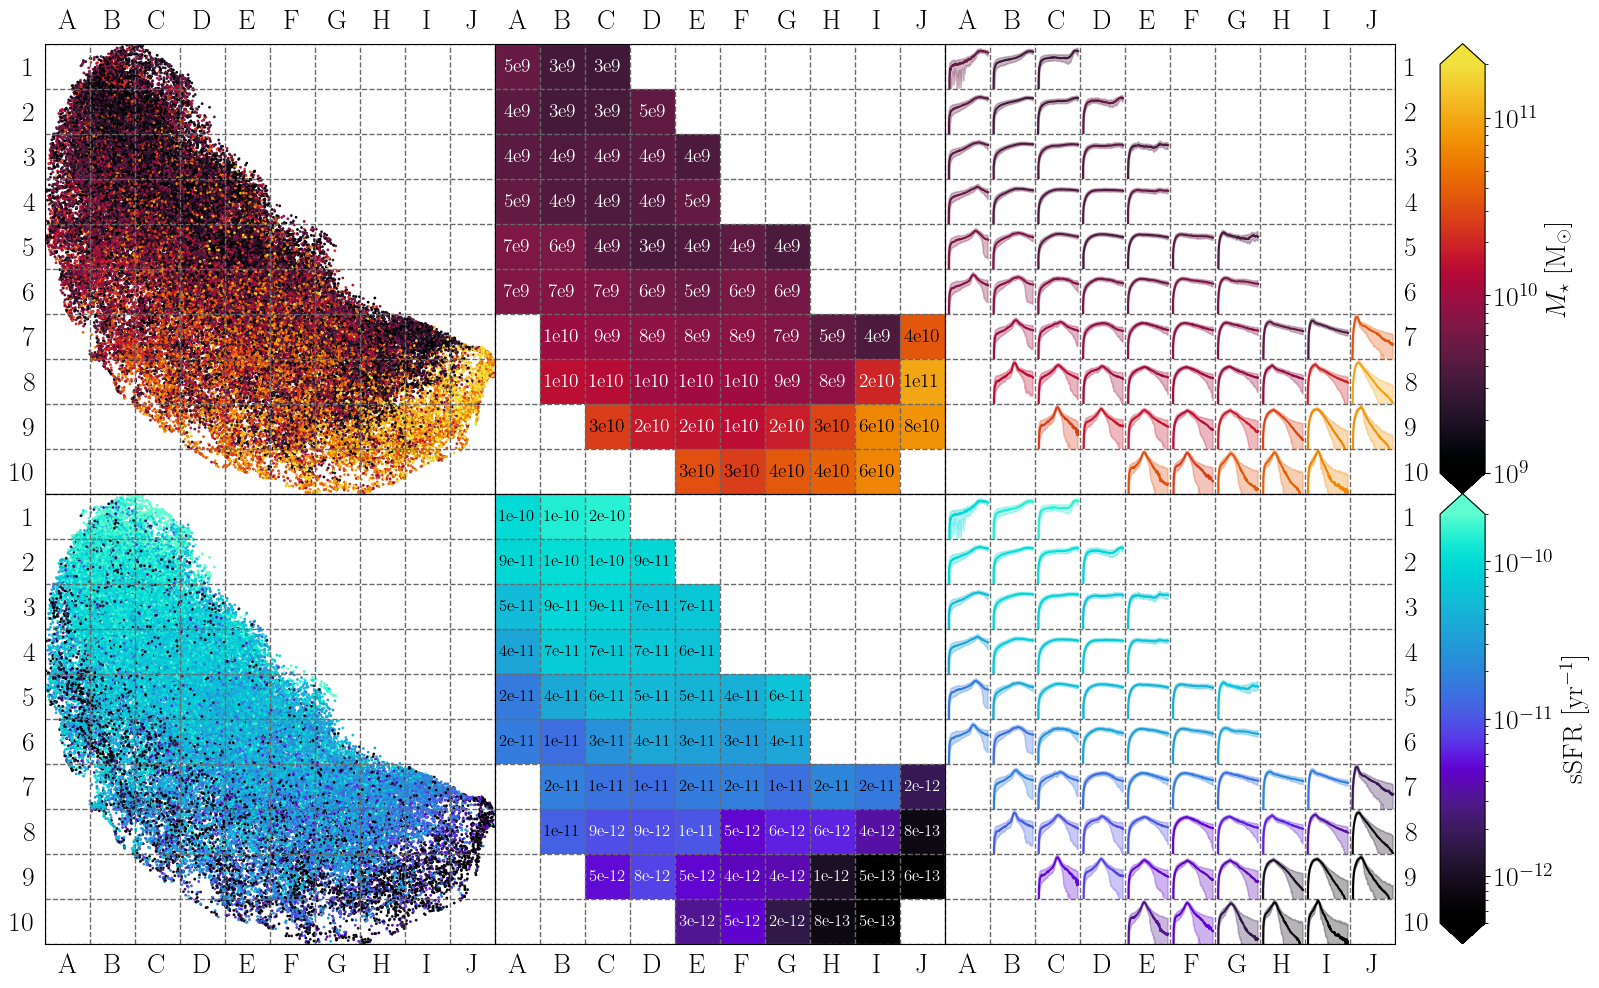

Figure 5 (stellar mass and SFR analysis) generated successfully!


In [5]:
# Set up colormaps
cmap = [cmr.ember, cmr.cosmic]

# Create the figure using draw_grid_D (2 rows x 3 columns)
fig, ax, norm = draw_grid_D(cmap1=cmap[0], vmin1=1e9, vmax1=2e11, lognorm1=True,
                           cmap2=cmap[1], vmin2=5e-13, vmax2=2e-10, lognorm2=True)

# Top row: Stellar Mass (SM)
plot_points(x=xy[:,0], y=xy[:,1], z=sm0,
           fig=fig, ax=ax[0], cax=ax[3], cmap=cmap[0], norm=norm[0], 
           extend='both', label=SM_axis_label)

plot_averages(10**sm_avg, avg_sfh, fig, ax[1], ax[2], umaps, cmap[0], norm[0], ftype='e')

# Bottom row: Specific SFR (sSFR)
plot_points(x=xy[:,0], y=xy[:,1], z=ssfr0,
           fig=fig, ax=ax[4], cax=ax[7], cmap=cmap[1], norm=norm[1], 
           extend='both', label=sSFR_axis_label)

plot_averages(10**sfr_avg, avg_sfh, fig, ax[5], ax[6], umaps, cmap[1], norm[1], ftype='e')

# Save figure
plt.savefig('../figures/umap_sm_sfr.png', bbox_inches='tight', dpi=300)
plt.savefig('../figures/umap_sm_sfr.pdf', bbox_inches='tight')

plt.show()

print("Figure 5 (stellar mass and SFR analysis) generated successfully!")

In [6]:
print("\nFigures saved to:")
print("- ../figures/umap_sm_sfr.png")
print("- ../figures/umap_sm_sfr.pdf")
print("\nFigure 5 shows stellar mass and SFR analysis with:")
print("- Top row: Stellar mass (z=0) point plots, averages, and SFHs")
print("- Bottom row: Specific SFR (z=0) point plots, averages, and SFHs")
print("- Color-coded by stellar mass (ember) and specific SFR (cosmic)")
print("- Average SFHs per battleship grid cell for both quantities")


Figures saved to:
- ../figures/umap_sm_sfr.png
- ../figures/umap_sm_sfr.pdf

Figure 5 shows stellar mass and SFR analysis with:
- Top row: Stellar mass (z=0) point plots, averages, and SFHs
- Bottom row: Specific SFR (z=0) point plots, averages, and SFHs
- Color-coded by stellar mass (ember) and specific SFR (cosmic)
- Average SFHs per battleship grid cell for both quantities
